In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
import numpy as np
from math import *
import matplotlib.pyplot as plt

%matplotlib notebook

exec(open("ode2.py").read(), globals())

## Reference

In [8]:
Freq_v = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 2., 2.5, 3.]
M_v = [0.8, 0.9, 1., 1.05, 1.1]
#nParall = len(M)

In [9]:
a = 0.2
m_ref = M_v[0]
Param_phy = [a, m_ref]
Init = [0, Param_phy[1]]

      
Init = [1., .5]


freq_ref = Freq_v[0]
Param_freq = {"p":  freq_ref}#2
dt = min([0.1, 0.1/Param_freq["p"]]) ### Use small $dt$ (it could increase when we change the frequency) CHANGED
dt_ref = dt
finalTime = 500
finalTime_ref = finalTime

Param_strength = {"scale":0.01} # 0.0008
Param_coupled = {"alpha":5., # 20
                 "beta":1.}# 500


Fire_param = {"model": "coupled",
                "frequence": "bernoulli",
                "param_freq" : Param_freq,
                "amplitude": "exponential",
                "Param_strength" : Param_strength,
                "Param_coupled" : Param_coupled,
                "type" : "proportionnal",
                "coef_W_N" : 5}

<Figure size 1296x432 with 0 Axes>

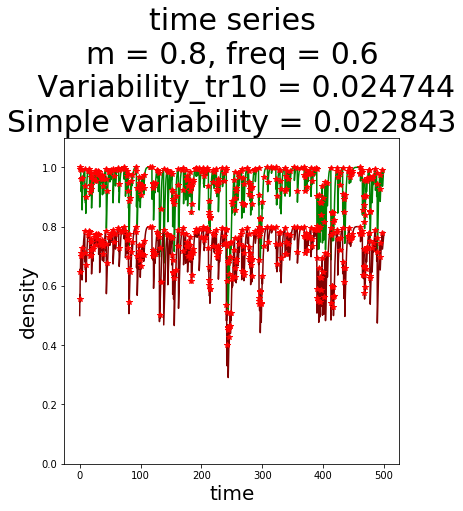

In [10]:
#Fire_events = np.zeros((nParall, 1000), dtype="bool")
#Fire_strength = np.zeros((nParall, 1000))

plt.figure(figsize = (18, 6))
O = Ode(model = "allee_effect_adi", Init=Init, Param_phy= Param_phy, finalTime = finalTime, dt=dt_ref, Fire_param = Fire_param)
nbreIter_ref = O.NbreIte
Fire_events = O.Fire_events
Fire_strength = O.Fire_strength
O.solve_by_part()
var = O.variability("N+W")
var_a = np.var(O.N+O.W)
#plt.figure(figsize = (12, 6))
#plt.subplot(1, nParall, j+1)
plt.figure(figsize = (6, 6))
O.plot_time_series(generation=False, show=False, legend = False)
plt.title("time series\nm = "+str(m_ref)+", freq = "+str(freq_ref)+"\n   Variability_tr10 = "+str(round(var, 6))+"\nSimple variability = "+str(round(var_a, 6)), fontsize = 30)
plt.show()

### Moving average

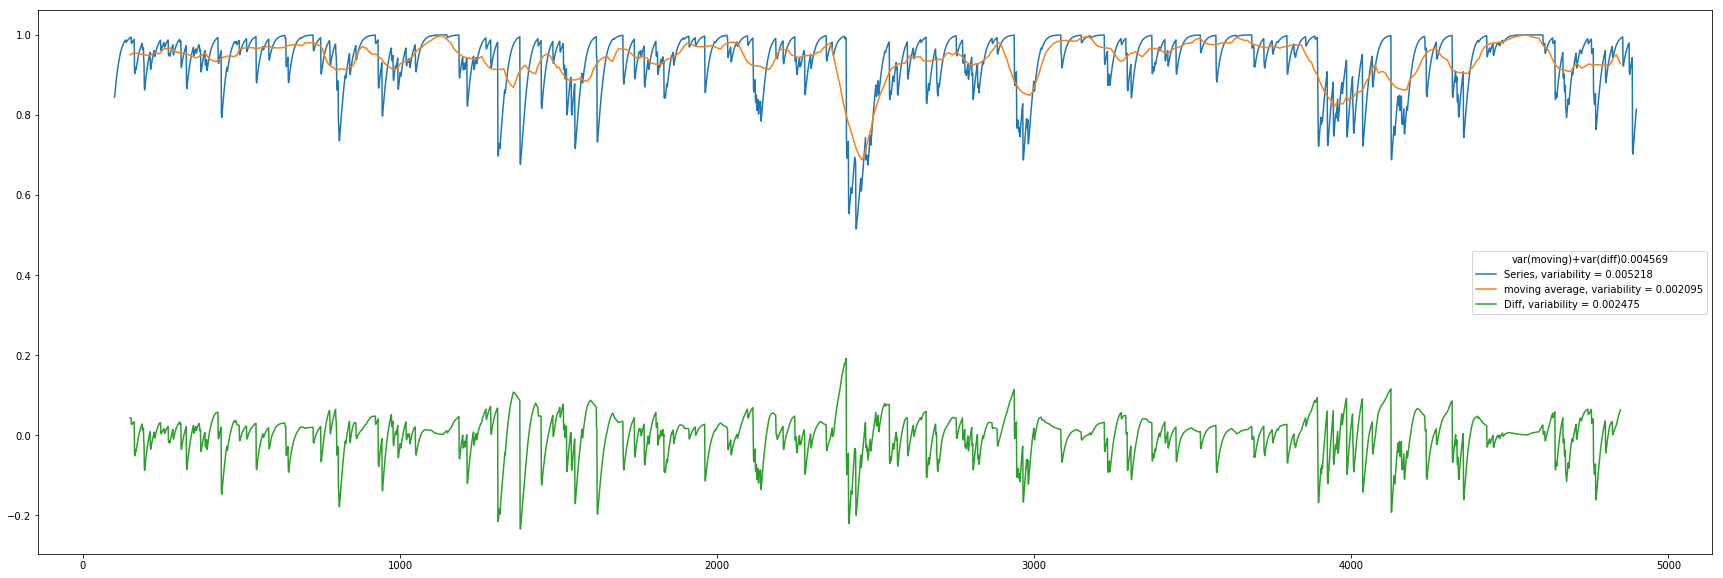

In [33]:
def moving_average(Series, length):
    Moving_average = np.convolve(Series, np.ones(length)/length, mode='full')[length//2:]
    Moving_average = Moving_average[:len(Series)]
    Moving_average[:length//2] = np.NaN
    Moving_average[-length//2:] = np.NaN
    Series[:length//2] = np.NaN
    Series[-length//2:] = np.NaN
    Diff = Series - Moving_average
    Diff[:length//2] = np.NaN
    Diff[-length//2:] = np.NaN
    return Series, Moving_average, Diff

length = 100
Series, Moving_average, Diff = moving_average(O.N, length)

var_series = np.nanvar(Series)
var_moving_average = np.nanvar(Moving_average)
var_diff = np.nanvar(Diff)

plt.figure(figsize = (30, 10))
plt.plot(Series, label="Series, variability = "+str(round(var_series, 6)))
plt.plot(Moving_average, label="moving average, variability = "+str(round(var_moving_average, 6)))
plt.plot(Diff, label="Diff, variability = "+str(round(var_diff, 6)))
plt.legend(title="var(moving)+var(diff)"+str(round(var_moving_average+var_diff, 6)))
plt.show()

#### Etirements de l'array Fire Fire_events[j, :] et Fire_strength[j]

In [47]:
def same(M, Freq, length, show=True):
    nParall = len(M)
    Var = np.zeros((len(Freq), nParall))
    Var_a = np.zeros((len(Freq), nParall))
    Var_series = np.zeros_like(Var)
    Var_moving_average = np.zeros_like(Var)
    Var_diff = np.zeros_like(Var)
    for i, freq in enumerate(Freq):
        ratio = round(freq/freq_ref, 4)
        #dt = round(dt_ref/ratio, 3)
        dt = dt_ref/ratio
        #finalTime  = round(finalTime_ref / ratio, 3)
        finalTime = finalTime_ref / ratio

        # Faire un dt plus inteligent pour eviter qu'il devienne trop grand
        #if(freq < freq_ref): #étirer
       # elif(freq > freq_ref):
        #    pass
        #else:
      #      dt = dt_ref

        #print("m = "+str(m))
        
        if(show):
            plt.figure(figsize = (30, 6))
        for j in range(nParall):
            Param_phy[1] = M[j]
            Init[1] = Param_phy[1]
            O = Ode(model = "allee_effect_adi", Init=Init, Param_phy= Param_phy, finalTime = finalTime, dt=dt, Fire_param = Fire_param)
            if(ratio > 1 ):
                O.Fire_events[:nbreIter_ref]  = Fire_events[:len(O.Fire_events)]
                O.Fire_strength[:nbreIter_ref] = Fire_strength[:len(O.Fire_strength)]

            elif(ratio < 1):
                O.Fire_events  = Fire_events[:len(O.Fire_events)]
                O.Fire_strength = Fire_strength[:len(O.Fire_strength)]
            else:
                O.Fire_events = Fire_events
                O.Fire_strength = Fire_strength  
            O.solve_by_part()
            var = O.variability("N+W")
            var_a = np.var(O.N+O.W)
            
            Var[i,j] = var
            Var_a[i,j] = var_a
            
            Series, Moving_average, Diff = moving_average(O.N+O.W, length)

            var_series = np.nanvar(Series)
            var_moving_average = np.nanvar(Moving_average)
            var_diff = np.nanvar(Diff)
            Var_series[i,j] = var_series
            Var_moving_average[i,j] = var_moving_average
            Var_diff[i,j] = var_diff
            
            if(show):
                plt.subplot(1, nParall, j+1)
                O.plot_time_series(generation=False, show=False, legend = False)
                plt.xlim(-2, 1.05*finalTime_ref)
                plt.title("time series\nm = "+str(M[j])+", freq = "+str(Freq[i])+"\n   Variability_tr10 = "+str(round(var, 6))+"\nSimple variability = "+str(round(var_a, 6))+"\nSeries variability = "+str(round(var_series, 6))+"\nMov. av. variability = "+str(round(var_moving_average, 6))+"\nDiff. variability = "+str(round(var_diff, 6)), fontsize = 21)
#        O.plot_time_series()
        if(show):
            plt.show()
    return Var, Var_a, Var_series, Var_moving_average, Var_diff

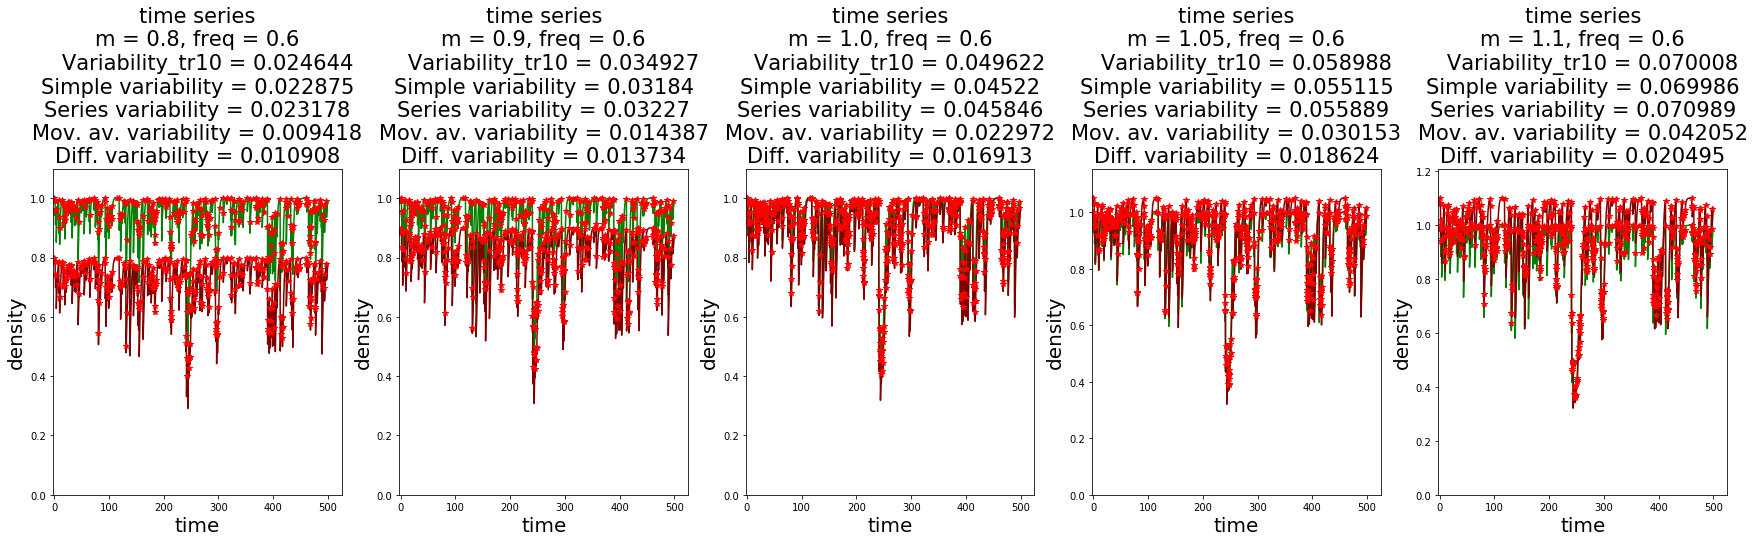

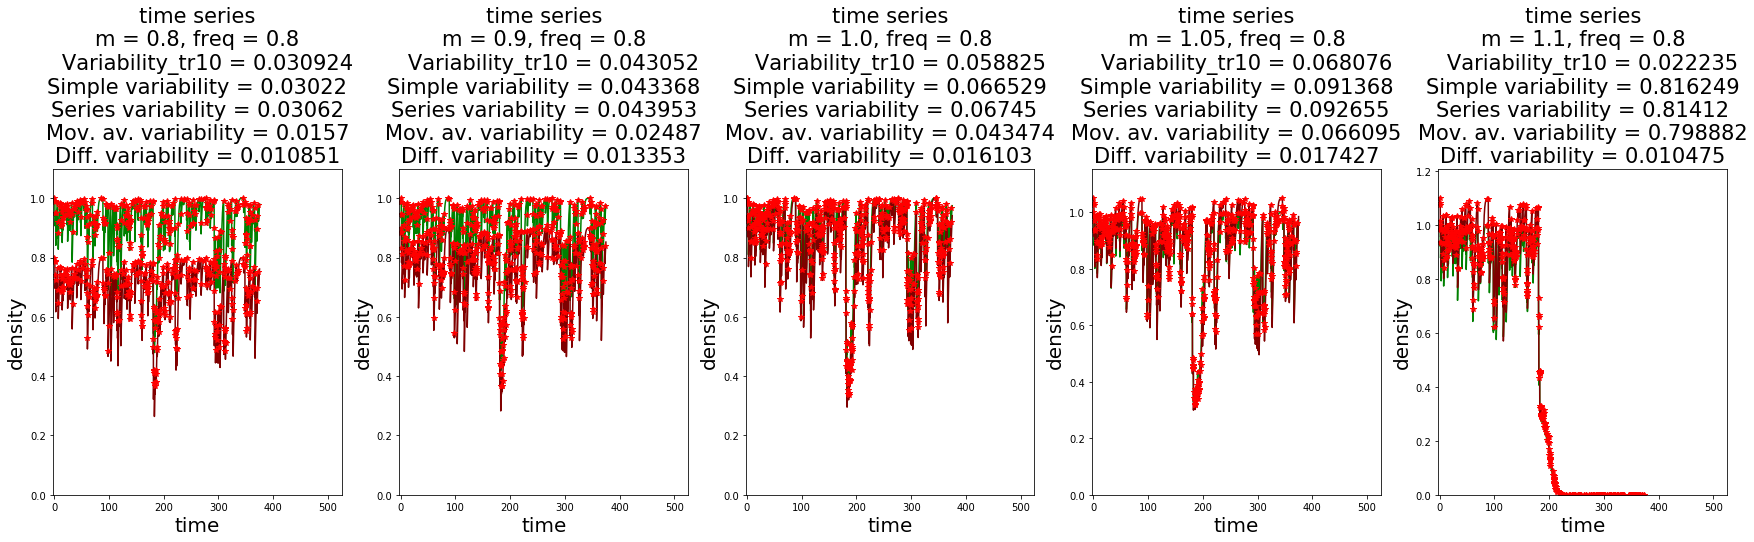

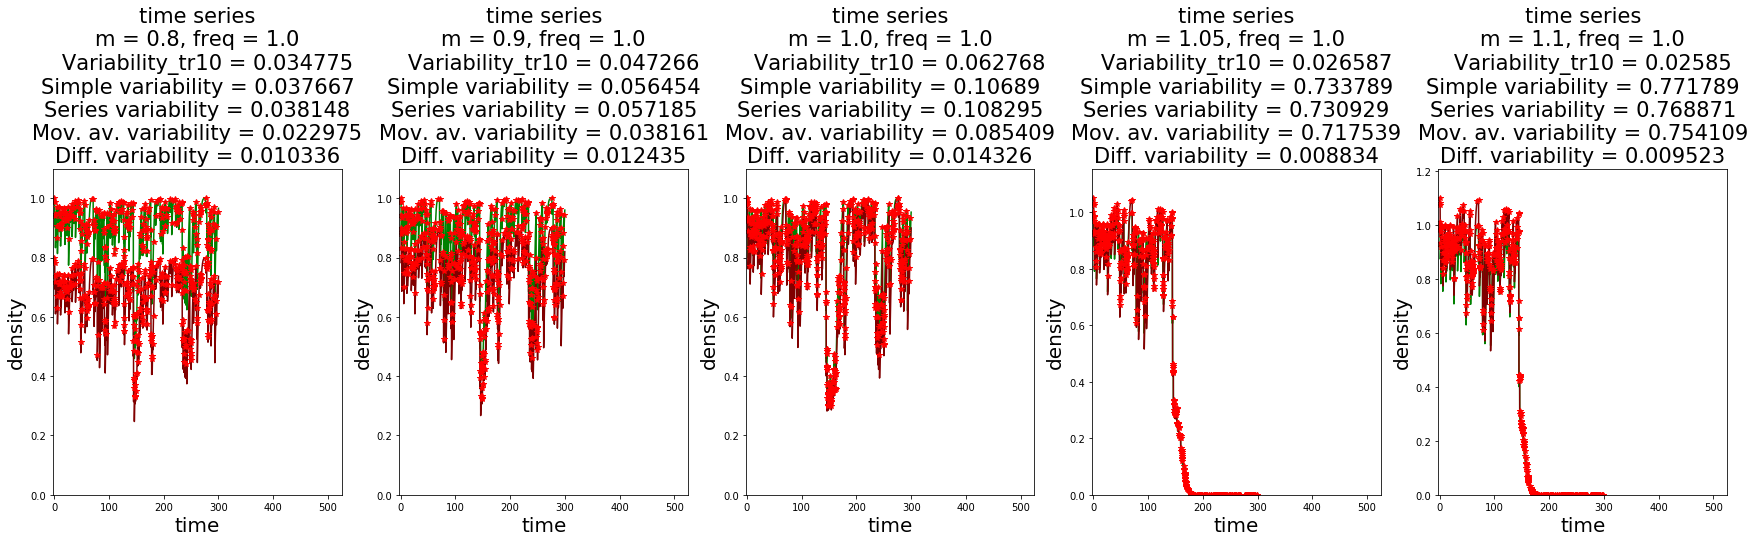

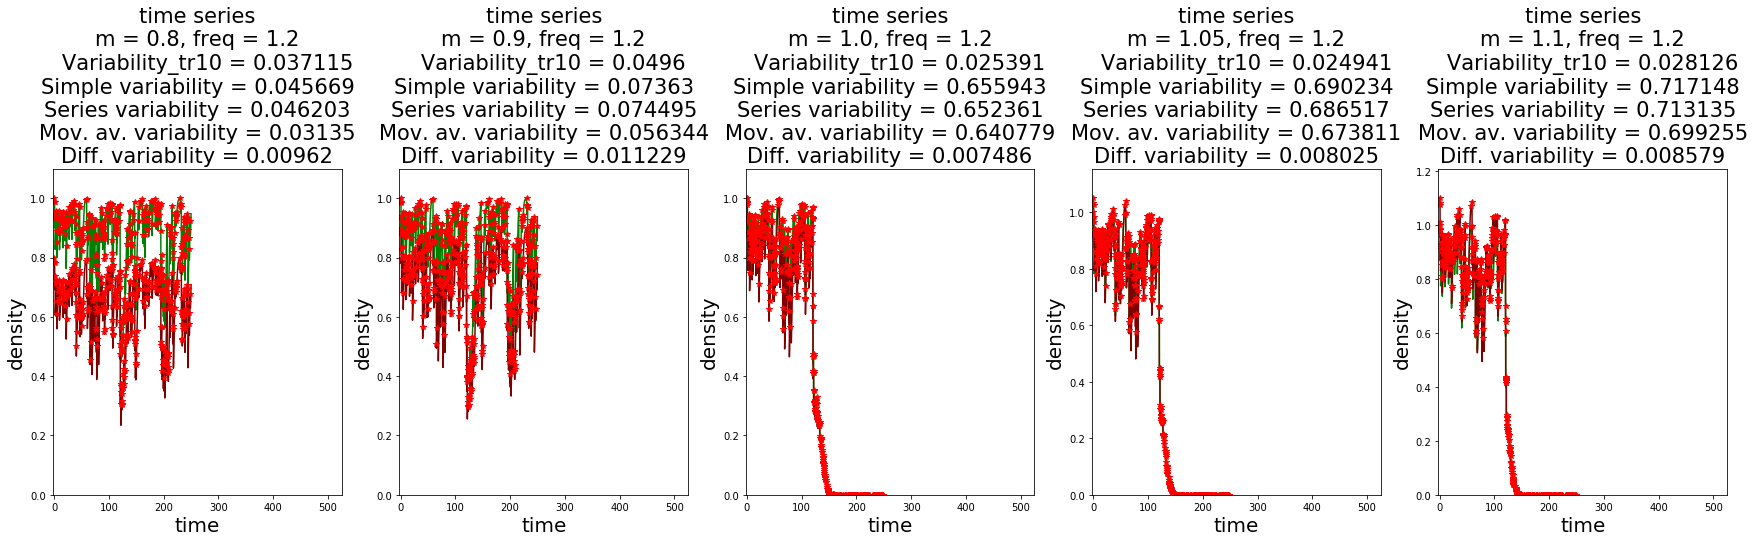

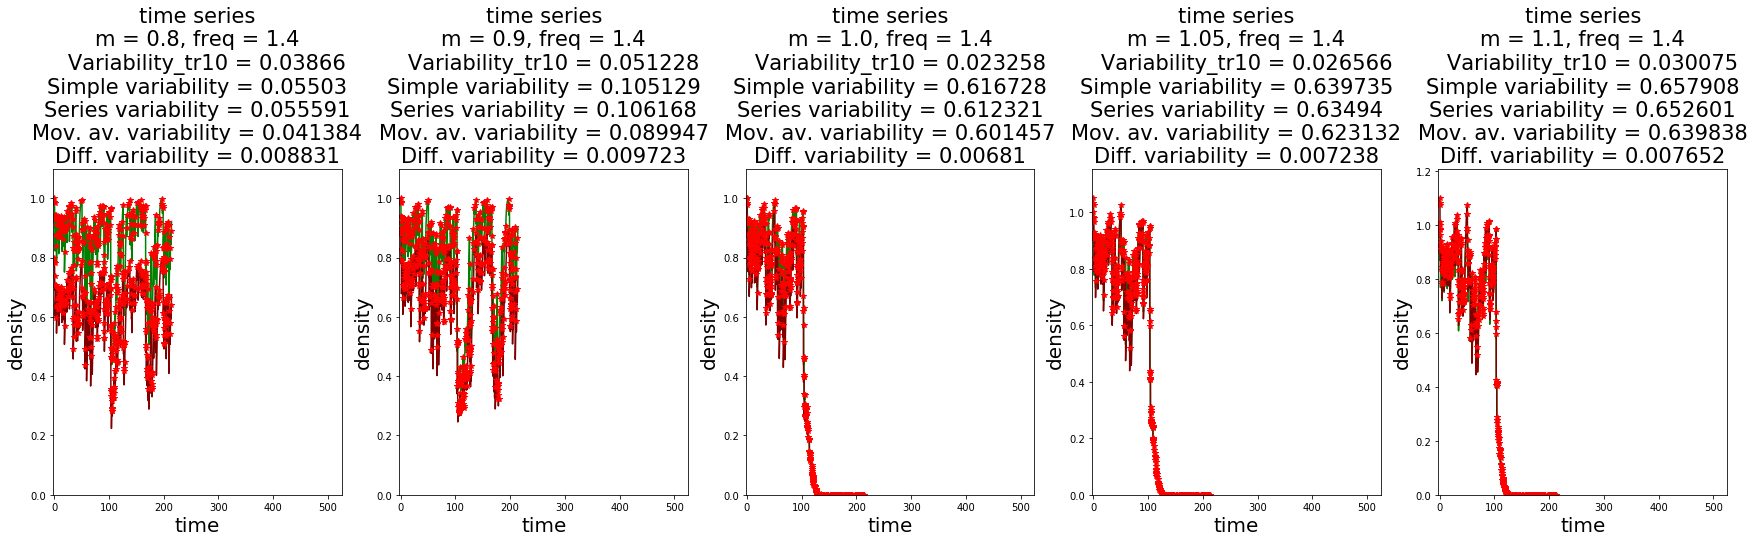

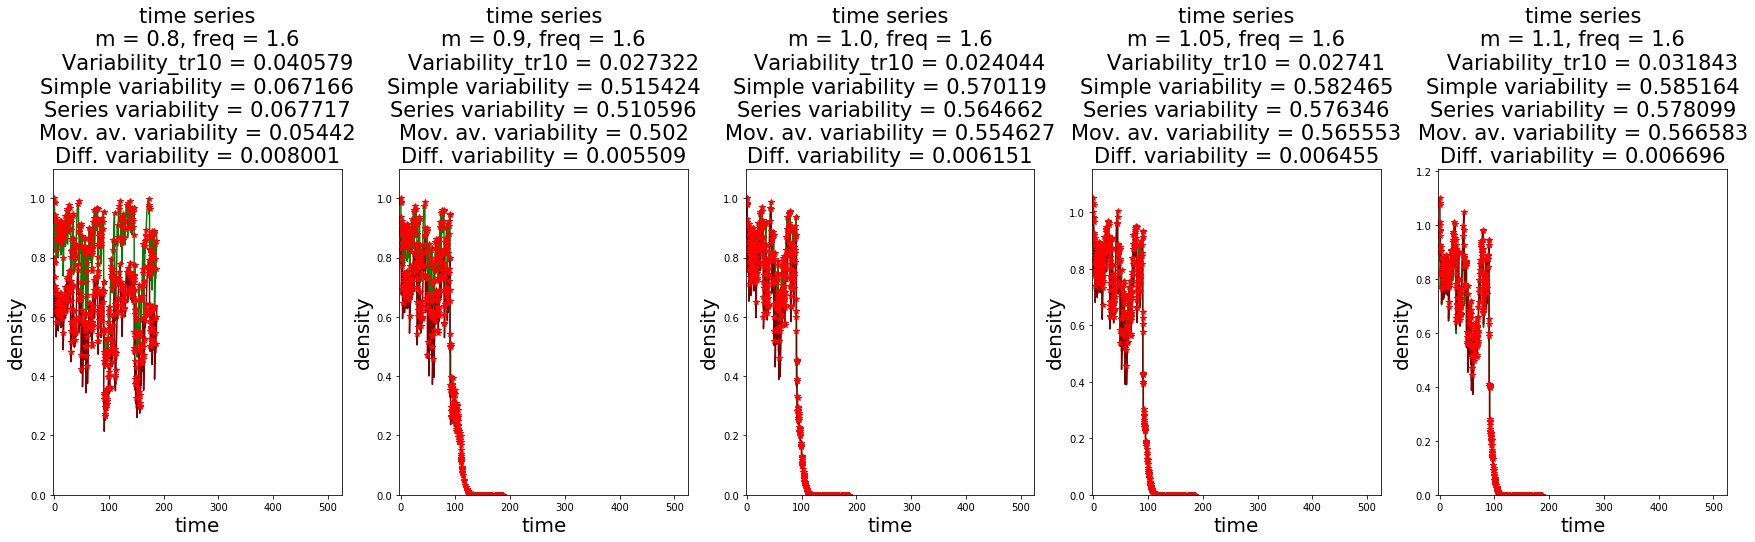

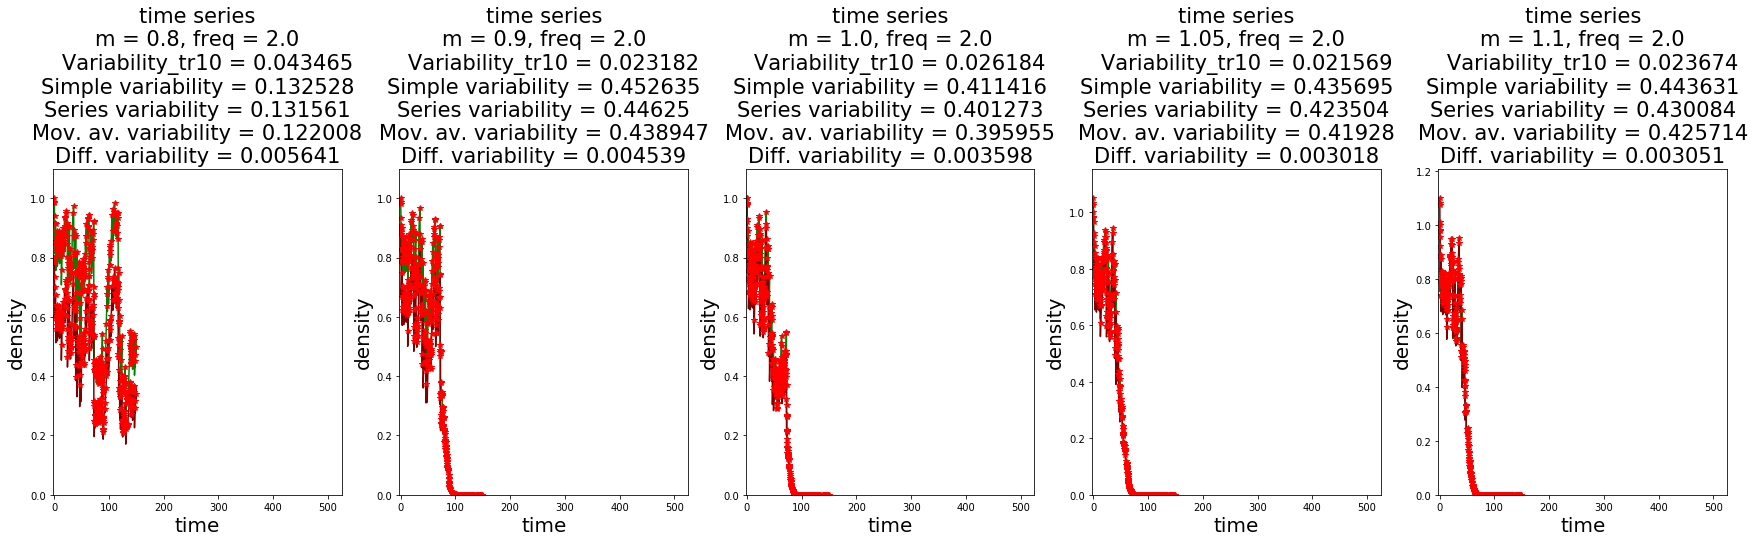

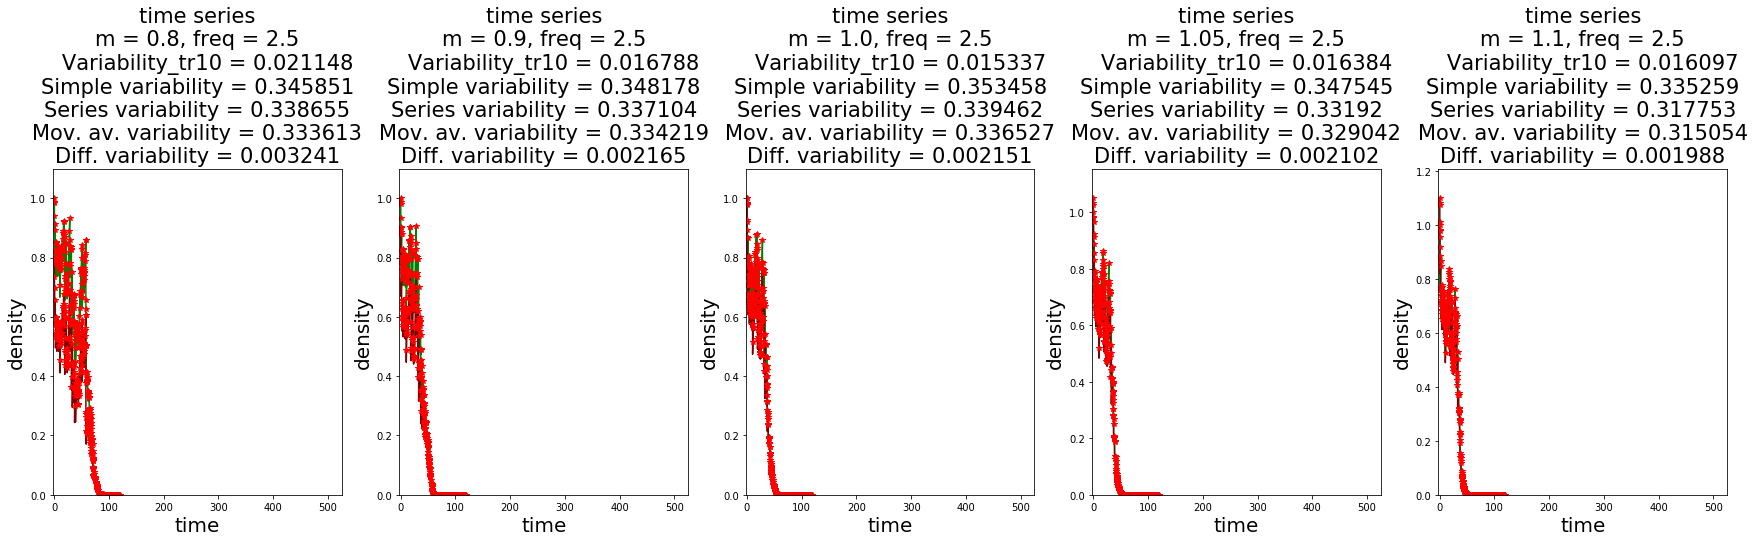

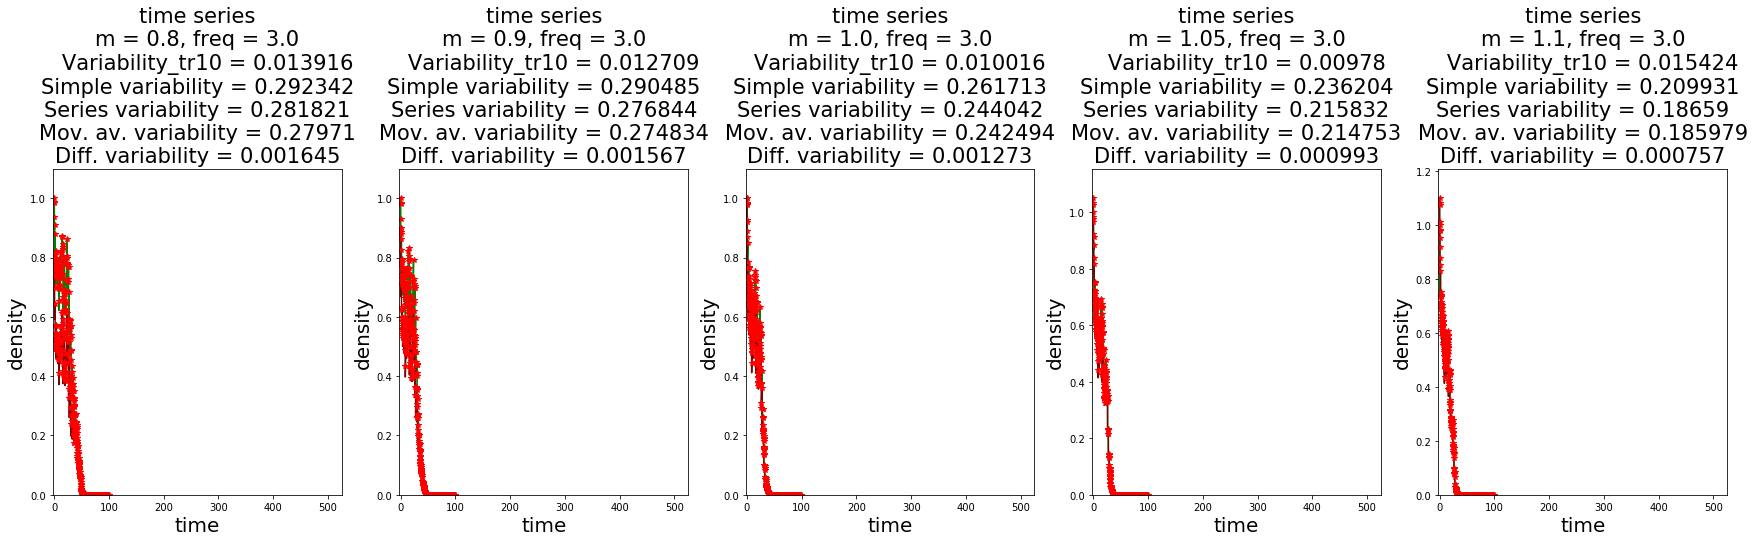

In [38]:
Var, Var_a, Var_series, Var_moving_average, Var_diff = same(M_v, Freq_v, show=True)

In [53]:
Freq_c = [0.5, 0.8, 1., 1.2, 1.4, 1.6, 1.8, 2., 2.5, 3., 4., 5., 6.]
# less point should be enough
M_c = [0.8, 0.9, 1., 1.05, 1.1]
Var, Var_a, Var_series, Var_moving_average, Var_diff = same(M_c, Freq_c, length=800, show = False)

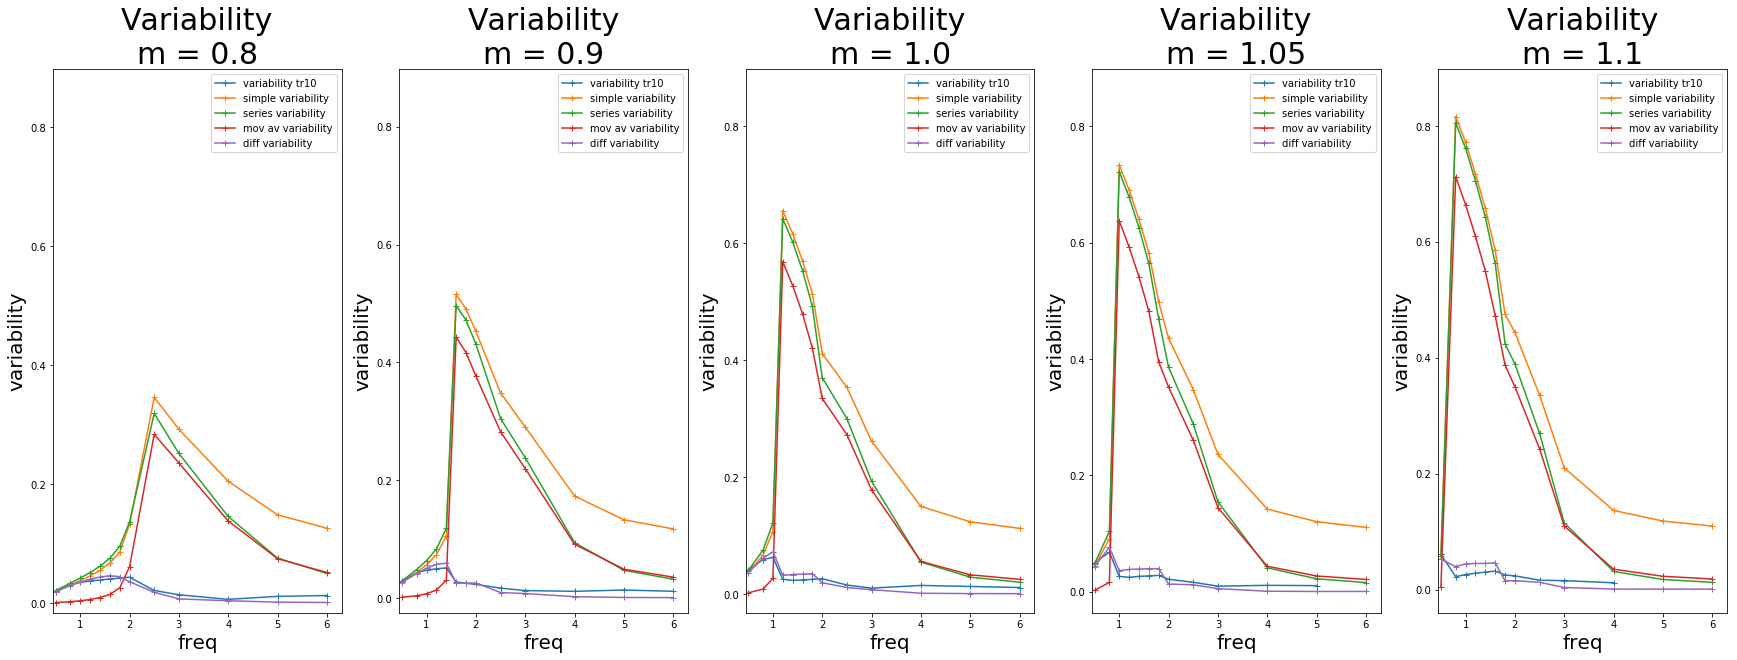

In [54]:
plt.figure(figsize = (30, 10))
mmax_tr10 = np.nanmax(np.nanmax(Var))
mmax_a = np.nanmax(np.nanmax(Var_a))
mmax_s = np.nanmax(np.nanmax(Var_series))
mmax_m = np.nanmax(np.nanmax(Var_moving_average))
mmax_d = np.nanmax(np.nanmax(Var_diff))
mmax = max([mmax_tr10, mmax_a, mmax_s, mmax_m, mmax_d])

for j,m in enumerate(M_c):
    plt.subplot(1, len(M_c), j+1)
    plt.plot(Freq_c, Var[:,j], "+-", label="variability tr10")
    plt.plot(Freq_c, Var_a[:,j], "+-", label="simple variability")
    plt.plot(Freq_c, Var_series[:,j], "+-", label="series variability")
    plt.plot(Freq_c, Var_moving_average[:,j], "+-", label="mov av variability")
    plt.plot(Freq_c, Var_diff[:,j], "+-", label="diff variability")
    plt.legend()
    plt.title("Variability\nm = "+str(M_c[j]), fontsize = 30)
    plt.xlabel("freq", fontsize = 20)
    plt.ylabel("variability", fontsize = 20)
    plt.ylim(top = 1.1*mmax)
    plt.xlim(0.9*Freq_c[0], 1.05*Freq_c[-1])
plt.show()

###### Link between small variation and variability tr10 ??

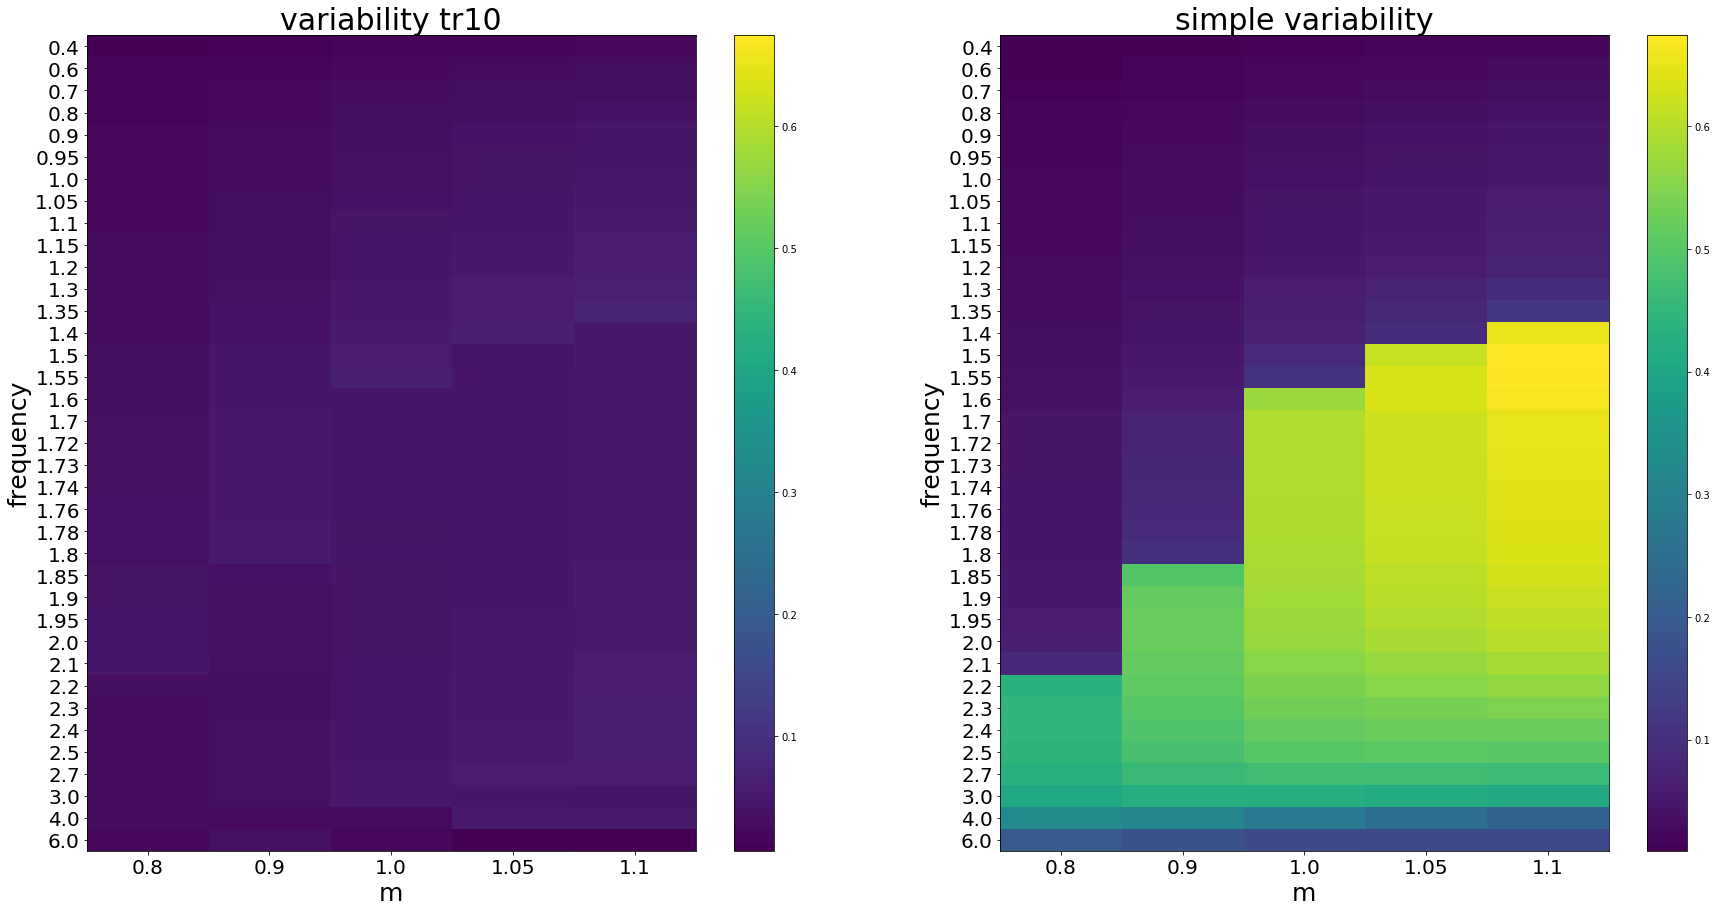

In [10]:
plt.subplots(figsize=(30, 15))

plt.subplot(1,2,1)
plt.title("variability tr10", fontsize = 30)
plt.imshow(Var, vmax=mmax, aspect="auto")
plt.xticks(np.arange(len(M_c)), M_c, fontsize=20)
plt.xlabel("m", fontsize=25)
plt.yticks(np.arange(len(Freq_c)), Freq_c, fontsize=20)
plt.ylabel("frequency", fontsize=25)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("simple variability", fontsize = 30)
plt.imshow(Var_a, vmax=mmax, aspect="auto")
plt.xticks(np.arange(len(M_c)), M_c, fontsize=20)
plt.xlabel("m", fontsize=25)
plt.yticks(np.arange(len(Freq_c)), Freq_c, fontsize=20)
plt.ylabel("frequency", fontsize=25)
plt.colorbar()

plt.show()

## Moving average

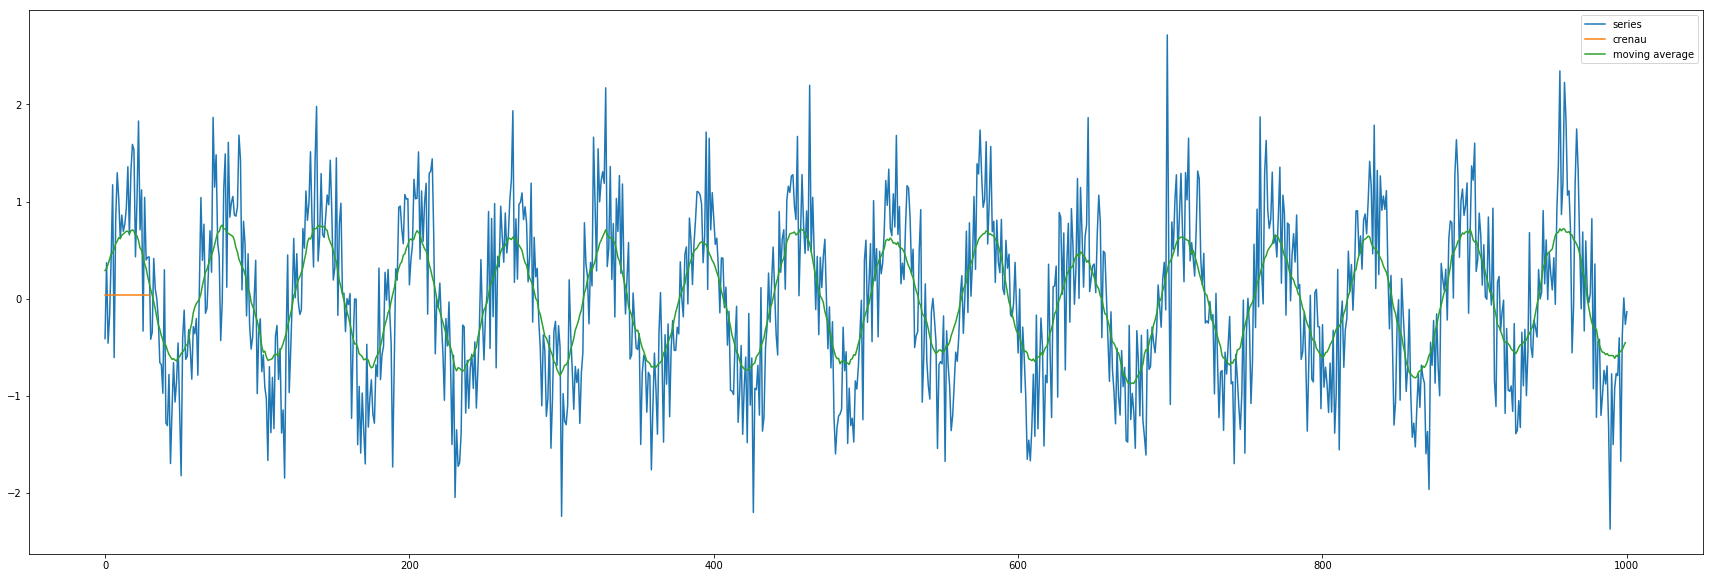

In [81]:
S = np.sin(1*np.linspace(0, 100, 1001)) 
S += 0.5*np.random.randn(len(S))
length = 30
C = np.ones(length)
#C = np.array([1, 1])
C = C / len(C)
Conv = np.convolve(C, S, mode="full")[length//2:-length//2]
#Conv = np.roll(Conv, -length//2)


plt.figure(figsize = (30, 10))
plt.plot(S, label="series")
plt.plot(C, label="crenau")
plt.plot(Conv, label="moving average")
plt.legend()
plt.show()

##  Filter

In [11]:
from scipy import interpolate
from scipy.signal import bspline
from scipy.signal import spline

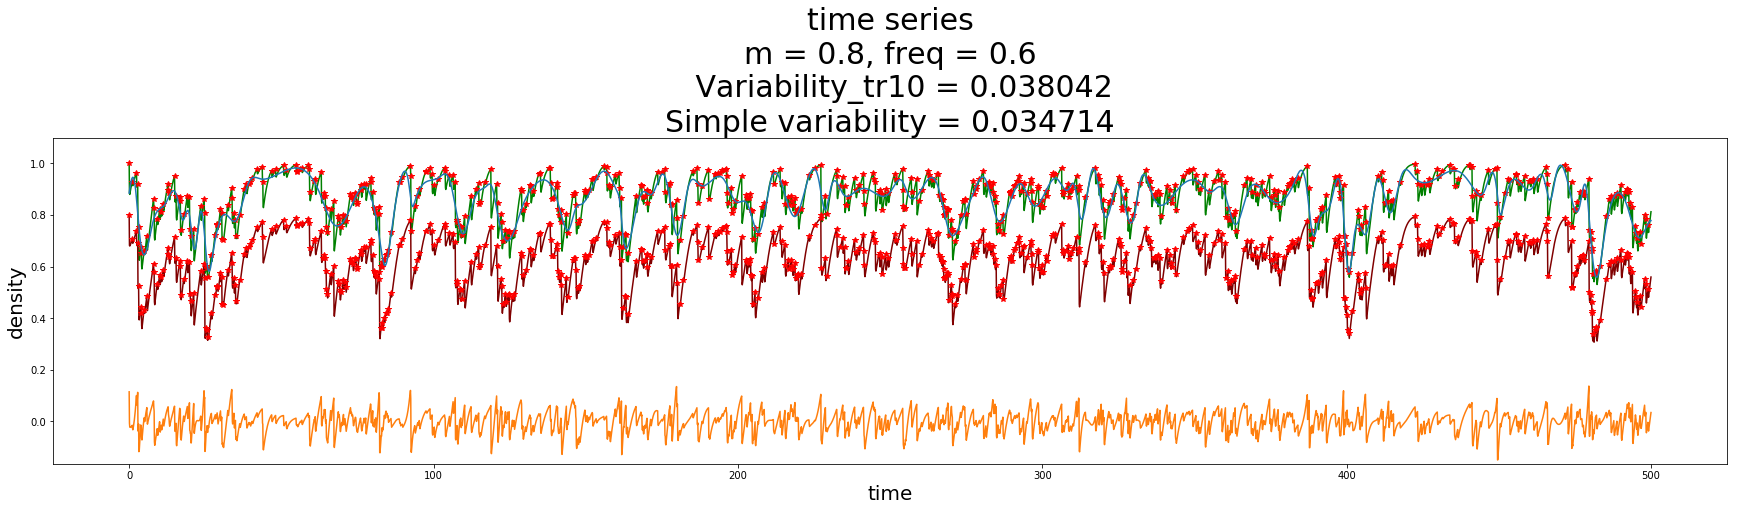

In [27]:
#Fire_events = np.zeros((nParall, 1000), dtype="bool")
#Fire_strength = np.zeros((nParall, 1000))
freq_ref = Freq_v[0]

m_ref = M_v[0]
Param_phy[1] = m_ref
Init[1] = Param_phy[1]
dt=dt_ref
O = Ode(model = "allee_effect_adi", Init=Init, Param_phy= Param_phy, finalTime = finalTime, dt=dt, Fire_param = Fire_param)
nbreIter_ref = O.NbreIte
O.solve_by_part()
var = O.variability("N+W")
var_a = np.var(O.N+O.W)
#plt.figure(figsize = (12, 6))
#plt.subplot(1, nParall, j+1)
plt.figure(figsize = (30, 6))
O.plot_time_series(generation=False, show=False, legend = False)

#############
s = interpolate.UnivariateSpline(O.Time, O.N, s=7)
plt.plot(O.Time, s(O.Time), label="smooth")
plt.plot(O.Time, O.N-s(O.Time), label="diff")
plt.ylim(1.1*min(O.N-s(O.Time)))

#############
#s2 = bspline(O.N, n=5)
#plt.plot(O.Time, s2)

#############
#s3 = spline(O.N, n=5)
#plt.plot(O.Time, s3)





plt.title("time series\nm = "+str(m_ref)+", freq = "+str(freq_ref)+"\n   Variability_tr10 = "+str(round(var, 6))+"\nSimple variability = "+str(round(var_a, 6)), fontsize = 30)
plt.show()

### La droite c'est pas justement du à une prop des splines ???? 
### Si

slope 0.00020013797605283884


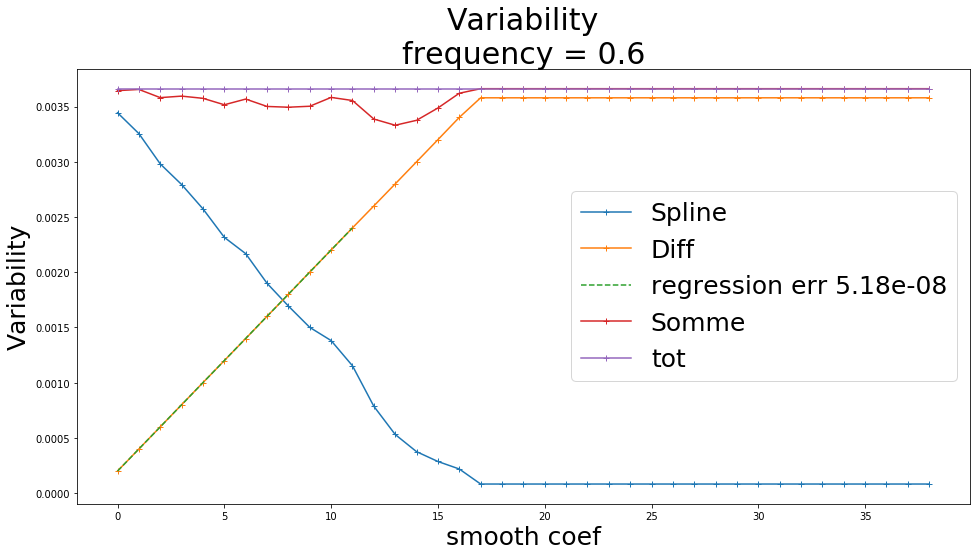

slope 0.00019997824922562117


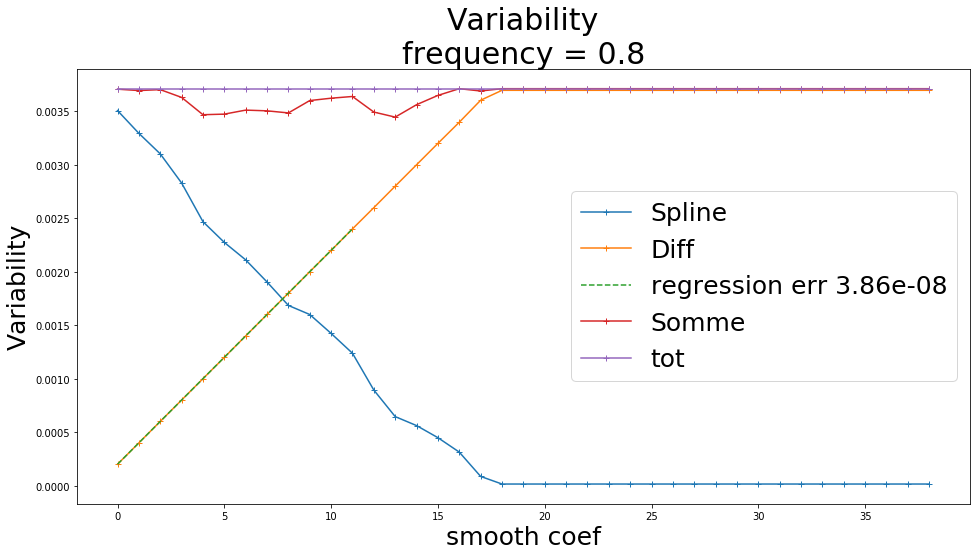

slope 0.000199939446255312


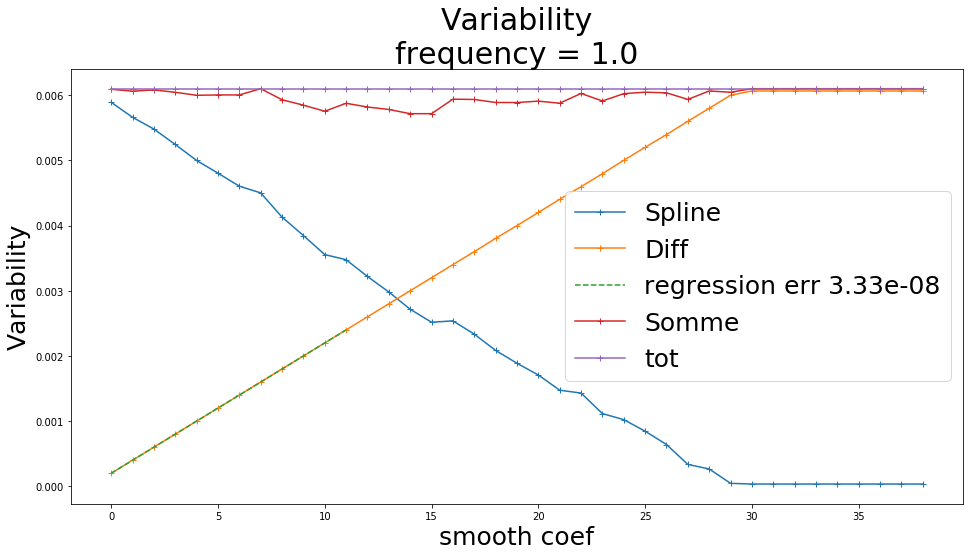

slope 0.0001999975340838103


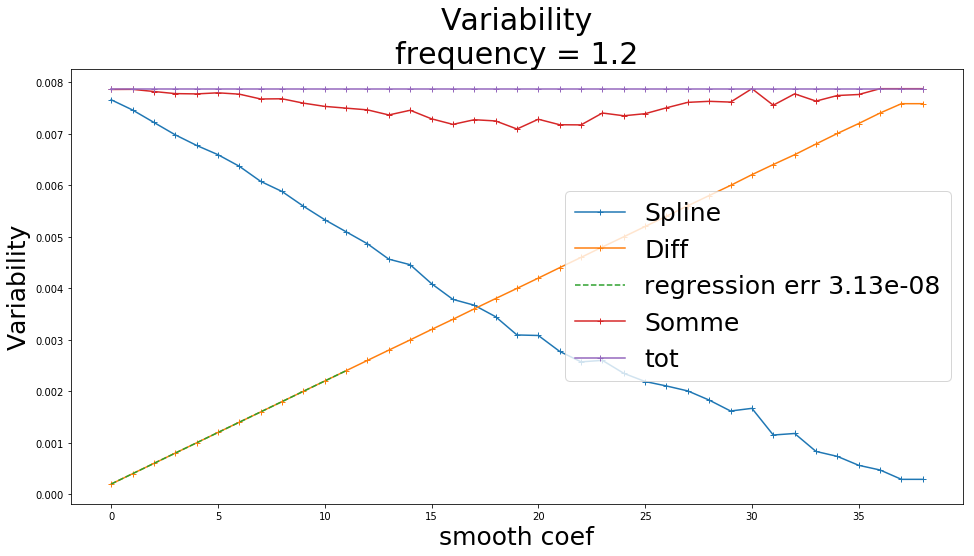

In [28]:
Freq2 = [0.6, 0.8, 1., 1.2]
for freq in Freq2:
    Param_freq = {"p":  freq}
    Fire_param["param_freq"] = Param_freq
    O = Ode(model = "allee_effect_adi", Init=Init, Param_phy= Param_phy, finalTime = finalTime, dt=dt, Fire_param = Fire_param)
    O.solve_by_part()
    Smooth = np.array([i for i in range(1, 40)])
    Spline = np.zeros(len(Smooth))
    Diff = np.zeros(len(Smooth))
    Somme = np.zeros(len(Smooth))
    Var = np.zeros(len(Smooth))
    for i, smooth in enumerate(Smooth):
        s = interpolate.UnivariateSpline(O.Time, O.N, s=smooth)
        Spline[i] = np.var(s(O.Time))
        Diff[i] = np.var(s(O.Time)-O.N)
        Somme[i] = np.var(s(O.Time))+ np.var(s(O.Time)-O.N)
        Var[i] = np.var(O.N)
    plt.figure(figsize=(16,8))
    plt.plot(Spline, "+-", label="Spline")
    plt.plot(Diff, "+-", label="Diff")    
    indice_max = 12
    a, b, coef, p_value, err = stats.linregress(Smooth[:indice_max], Diff[:indice_max])
    plt.plot(Smooth[:(indice_max)]*a+b, "--", label="regression err "+"%.2e" % err)
    print("slope", a)
    plt.plot(Somme, "+-", label="Somme")
    plt.plot(Var, "+-", label="tot")
    plt.xlabel("smooth coef", fontsize=25)
    plt.ylabel("Variability", fontsize=25)
    plt.title("Variability\nfrequency = "+str(freq), fontsize = 30)
    plt.legend(fontsize=25)
    plt.show()

## Fourier

In [ ]:
F = np.fft.fft(O.N-np.mean(O.N))
F = F[:len(F)//2:]
plt.plot(F)
#plt.xlim(0, 100)
plt.show()

## Poincaré plot

In [3]:
def autocorr(X):
    A = np.zeros(len(X))
    for i in range(len(X)):
        A[i] = 1./len(X) * sum(X*np.roll(X, -i))
    return A       

In [ ]:
#A = np.correlate(O.N, O.N, mode="full")
A = autocorr(O.N)

In [ ]:
plt.plot(O.Time[:len(O.Time)//2], A[:len(O.Time)//2])
plt.title("Auto correlation of A", fontsize = 25)
plt.xlabel("time", fontsize = 20)
plt.show()